In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, r2_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
pd.set_option("display.max_columns", None)

In [2]:
train_df = pd.read_csv("train_star.csv")
test_df = pd.read_csv("test_star.csv")

In [3]:
train_df.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType', 'Amag', 'TargetClass'], dtype='object')

In [4]:
train_df.head(), test_df.head()

(    Vmag    Plx  e_Plx    B-V  SpType       Amag TargetClass
 0   9.99   7.92   1.61  0.646  G5/G6V  19.483625       Giant
 1  10.86   3.26   2.12  1.840    M1V:  18.426088       Giant
 2   8.83   7.57   1.05  0.461     F3V  18.225480       Giant
 3   7.72  24.80   0.89  0.613    G3IV  19.692257       Giant
 4   8.81   3.17   1.03  0.872   G6III  16.315296       Dwarf,
    Vmag   Plx  e_Plx    B-V    SpType       Amag
 0  7.91  6.33   1.01  0.843     G5III  16.917019
 1  7.35  1.30   0.53  1.304  K1/K2III  12.919716
 2  6.75  8.01   0.84  1.019     K1III  16.268162
 3  4.47  7.03   0.72  1.283     K4III  13.704777
 4  7.33  2.45   1.14  1.600     K5III  14.275830)

In [5]:
train_df.info(), test_df.info() # nanoв нет - это хорошо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20732 entries, 0 to 20731
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vmag         20732 non-null  float64
 1   Plx          20732 non-null  float64
 2   e_Plx        20732 non-null  float64
 3   B-V          20732 non-null  float64
 4   SpType       20732 non-null  object 
 5   Amag         20732 non-null  float64
 6   TargetClass  20732 non-null  object 
dtypes: float64(5), object(2)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18820 entries, 0 to 18819
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    18820 non-null  float64
 1   Plx     18820 non-null  float64
 2   e_Plx   18820 non-null  float64
 3   B-V     18820 non-null  float64
 4   SpType  18820 non-null  object 
 5   Amag    18820 non-null  float64
dtypes: float64(5), object(1)
memory usage: 882.3+ KB


(None, None)

Заменим метки классов на числа: гигант - 1, карлик - 0

In [6]:
train_df = train_df.map(lambda value: {"Giant": 1, "Dwarf": 0}.get(value, value))
test_df = test_df.map(lambda value: {"Giant": 1, "Dwarf": 0}.get(value, value))

## Data analysis

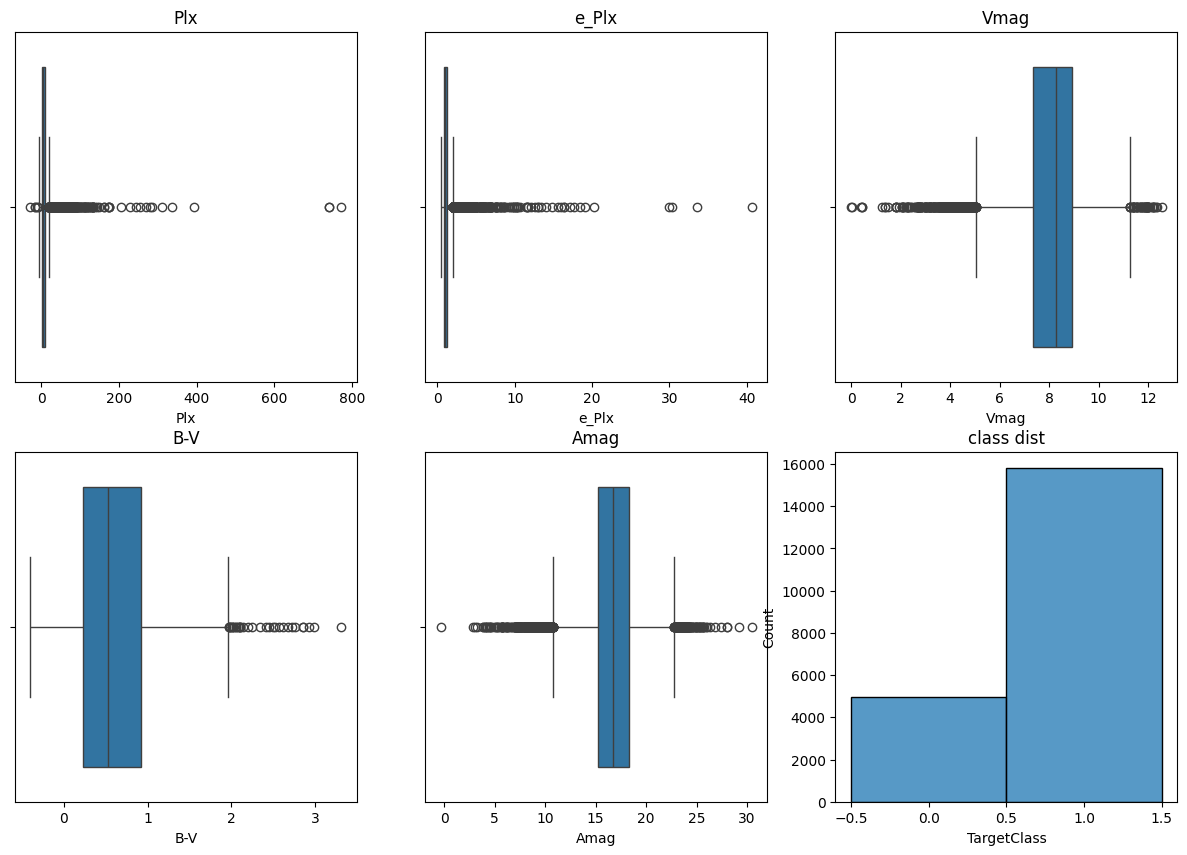

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].set_title("Plx")
sns.boxplot(data=train_df, x="Plx", ax=ax[0, 0])
ax[0, 1].set_title("e_Plx")
sns.boxplot(data=train_df, x="e_Plx", ax=ax[0, 1])
ax[0, 2].set_title("Vmag")
sns.boxplot(data=train_df, x="Vmag", ax=ax[0, 2])
ax[1, 0].set_title("B-V")
sns.boxplot(data=train_df, x="B-V", ax=ax[1, 0])
ax[1, 1].set_title("Amag")
sns.boxplot(data=train_df, x="Amag", ax=ax[1, 1])
ax[1, 2].set_title("class dist")
sns.histplot(data=train_df, x="TargetClass", discrete=True)
plt.show()

На первый взгляд много выбросов и присутствует дизбаланс классов.

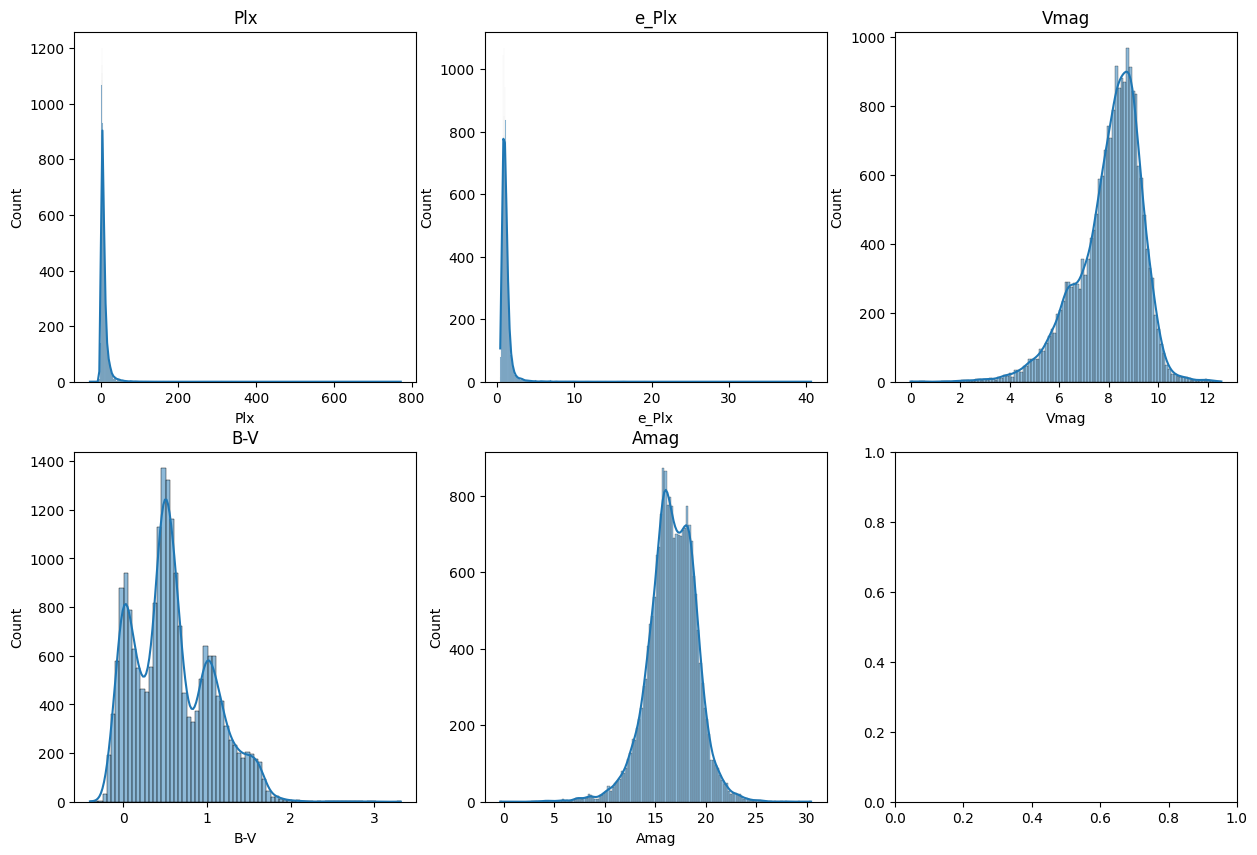

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].set_title("Plx")
sns.histplot(data=train_df, x="Plx", ax=ax[0, 0], kde=True)
ax[0, 1].set_title("e_Plx")
sns.histplot(data=train_df, x="e_Plx", ax=ax[0, 1], kde=True)
ax[0, 2].set_title("Vmag")
sns.histplot(data=train_df, x="Vmag", ax=ax[0, 2], kde=True)
ax[1, 0].set_title("B-V")
sns.histplot(data=train_df, x="B-V", ax=ax[1, 0], kde=True)
ax[1, 1].set_title("Amag")
sns.histplot(data=train_df, x="Amag", ax=ax[1, 1], kde=True)
plt.show()

In [9]:
class_weight = train_df["TargetClass"].value_counts() / len(train_df)
class_weight = class_weight.to_dict()

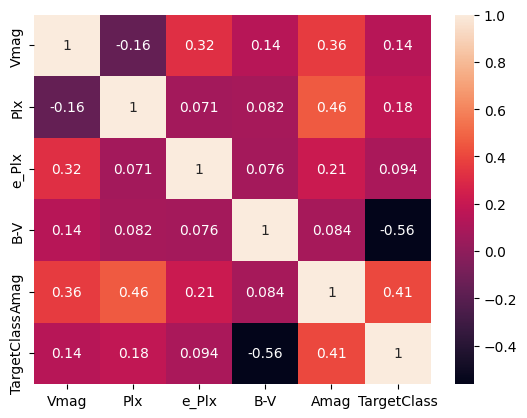

In [10]:
sns.heatmap(train_df.drop(columns=["SpType"]).corr(), annot=True)
plt.show()

## Some useful functions

In [11]:
def test_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    print("f1-score: ", f1_score(y_val, y_pred))
    print("r2-score: ", r2_score(y_val, y_pred))

def save_solution(model, X_test, filename="solution.csv"):
    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame(y_pred, columns=['TargetClass'])
    y_pred = y_pred.reset_index()

    y_pred.to_csv(filename, index=False)

## Baseline

Убираем SpType и смотрим на метрики линейной регрессии

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop(columns=["TargetClass", "SpType"]), train_df["TargetClass"], test_size=0.2, random_state=42)
X_test = test_df.drop(columns=["SpType"])

In [13]:
baseline = LogisticRegression().fit(X_train, y_train)
test_model(baseline, X_val, y_val)
save_solution(baseline, X_test)

f1-score:  0.937892095357591
r2-score:  0.4763755324847587


## Simple One-hot encoding

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(columns=["TargetClass"]),
    train_df["TargetClass"],
    test_size=0.2,
    random_state=42,
)

In [15]:
preprocessor = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(handle_unknown="ignore"), ["SpType"])],
    remainder="passthrough",
)

pipeline = Pipeline(
    [("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=300, class_weight="balanced"))]
)
pipeline.fit(X_train, y_train)
test_model(pipeline, X_val, y_val)
save_solution(pipeline, test_df)

f1-score:  0.9847279669105949
r2-score:  0.8730607351478203


## Cleaning

In [16]:
mask = (train_df["e_Plx"] < 5) & (train_df["Plx"] < 100) & (train_df["Vmag"] > 5) & (train_df["Vmag"] < 12)
filtered_df = train_df[mask]
X_train, X_val, y_train, y_val = train_test_split(
    filtered_df.drop(columns=["TargetClass"]),
    filtered_df["TargetClass"],
    test_size=0.2,
    random_state=42,
)

In [17]:
preprocessor = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(handle_unknown="ignore"), ["SpType"])],
    remainder="passthrough",
)

pipeline = Pipeline(
    [("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=300, class_weight="balanced"))]
)
pipeline.fit(X_train, y_train)
test_model(pipeline, X_val, y_val)
save_solution(pipeline, test_df)

f1-score:  0.9873125720876585
r2-score:  0.8949281993883085


## HARD Cleaning

In [18]:
filtered = train_df.copy()
for col in filtered.select_dtypes(include="number").columns:
    Q1 = filtered[col].quantile(0.25)
    Q3 = filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    filtered = filtered.query(f'(@Q1 - 1.5 * @IQR) <= `{col}` <= (@Q3 + 1.5 * @IQR)')
    print(col, Q1 - 1.5*IQR, Q3 + 1.5*IQR)
filtered.shape, train_df.shape

Vmag 5.030000000000001 11.27
Plx -7.45 20.310000000000002
e_Plx 0.12999999999999978 1.9700000000000002
B-V -0.9115000000000002 2.0365
Amag 11.025606499999999 22.127650499999998
TargetClass -1.5 2.5


((17460, 7), (20732, 7))

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    filtered.drop(columns=["TargetClass"]),
    filtered["TargetClass"],
    test_size=0.2,
    random_state=42,
)

In [20]:
preprocessor = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(handle_unknown="ignore"), ["SpType"])],
    remainder="passthrough",
)

pipeline = Pipeline(
    [("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=300, class_weight="balanced"))]
)
pipeline.fit(X_train, y_train)
test_model(pipeline, X_val, y_val)
save_solution(pipeline, test_df)

f1-score:  0.9860302677532014
r2-score:  0.8929175147479904


### Add temperature and decompose SpType

In [ ]:
def color_to_temperature(df):
    b_v = df['B-V']
    
    df['temp_approx'] = 4600 * (1/(0.92 * b_v + 1.7) + 1/(0.92 * b_v + 0.62))
    
    return df

In [ ]:
import re


def create_multihot_spectral(df):
    """
    Create multi-hot encoded features for spectral types
    """
    df = df.copy()

    spectral_classes = ["O", "B", "A", "F", "G", "K", "M"]
    subclasses = [str(i) for i in range(11)]  # 0-10, including decimal like '5.5'
    luminosity_classes = ["I", "II", "III", "IV", "V", "VI", "VII"]

    for spec_class in spectral_classes:
        df[f"spec_{spec_class}"] = df["SpType"].str.contains(spec_class).astype(int)

    def extract_subclass_presence(sp_type, subclass):
        pattern = r"(?<=[OBAFGKM])" + re.escape(subclass) + r"(?![0-9])"
        return 1 if re.search(pattern, sp_type) else 0

    for subclass in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]:
        df[f"subclass_{subclass}"] = df["SpType"].apply(
            lambda x: extract_subclass_presence(x, subclass)
        )

    for lum_class in luminosity_classes:
        df[f"lum_{lum_class}"] = df["SpType"].str.contains(lum_class).astype(int)

    df["num_spectral_classes"] = df[[f"spec_{c}" for c in spectral_classes]].sum(axis=1)
    df["num_subclasses"] = df[
        [
            f"subclass_{s}"
            for s in ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
        ]
    ].sum(axis=1)

    return df

In [47]:
create_multihot_spectral(train_df).head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,spec_O,spec_B,spec_A,spec_F,spec_G,spec_K,spec_M,subclass_0,subclass_1,subclass_2,subclass_3,subclass_4,subclass_5,subclass_6,subclass_7,subclass_8,subclass_9,subclass_10,lum_I,lum_II,lum_III,lum_IV,lum_V,lum_VI,lum_VII,num_spectral_classes,num_subclasses
0,9.99,7.92,1.61,0.646,G5/G6V,19.483625,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,2
1,10.86,3.26,2.12,1.840,M1V:,18.426088,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
2,8.83,7.57,1.05,0.461,F3V,18.225480,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,7.72,24.80,0.89,0.613,G3IV,19.692257,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1
4,8.81,3.17,1.03,0.872,G6III,16.315296,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,1


In [43]:
train_df.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,9.99,7.92,1.61,0.646,G5/G6V,19.483625,1
1,10.86,3.26,2.12,1.840,M1V:,18.426088,1
2,8.83,7.57,1.05,0.461,F3V,18.225480,1
3,7.72,24.80,0.89,0.613,G3IV,19.692257,1
4,8.81,3.17,1.03,0.872,G6III,16.315296,0


In [48]:
filtered_train

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,spec_O,spec_B,spec_A,spec_F,spec_G,spec_K,spec_M,subclass_0,subclass_1,subclass_2,subclass_3,subclass_4,subclass_5,subclass_6,subclass_7,subclass_8,subclass_9,subclass_10,lum_I,lum_II,lum_III,lum_IV,lum_V,lum_VI,lum_VII,num_spectral_classes,num_subclasses
0,9.99,7.92,1.61,0.646,G5/G6V,19.483625,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,2
1,10.86,3.26,2.12,1.840,M1V:,18.426088,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
2,8.83,7.57,1.05,0.461,F3V,18.225480,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,7.72,24.80,0.89,0.613,G3IV,19.692257,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1
4,8.81,3.17,1.03,0.872,G6III,16.315296,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20727,7.07,14.88,0.90,0.586,F8V,17.933014,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1
20728,9.11,4.71,0.87,0.485,F5V,17.475105,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1
20729,9.69,1.61,1.56,0.384,A2/A3IV,15.724129,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,2
20730,8.06,37.33,0.97,0.758,K1V,20.920290,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [71]:
mask = (
    (train_df["e_Plx"] < 5)
    & (train_df["Plx"] < 100)
    & (train_df["Vmag"] > 5)
    & (train_df["Vmag"] < 12)
)
extended_train = train_df[mask]
extended_train = color_to_temperature(create_multihot_spectral(extended_train).drop(columns=["SpType"]))
extended_test = color_to_temperature(create_multihot_spectral(test_df).drop(columns=["SpType"]))

In [75]:
extended_train.shape

(20053, 34)

In [76]:
X_train, X_val, y_train, y_val = train_test_split(
    extended_train.drop(columns=["TargetClass"]),
    extended_train["TargetClass"],
    test_size=0.2,
    random_state=42,
)
model = LogisticRegression(max_iter=5000, class_weight="balanced")
model.fit(X_train, y_train)
test_model(pipeline, X_val, y_val)
save_solution(pipeline, extended_test)

f1-score:  1.0
r2-score:  1.0


In [77]:
coeff_df = pd.DataFrame(model.coef_.flatten(), columns=['Coefficient'])  
coeff_df['features'] = extended_train.drop(columns=["TargetClass"]).columns

coeff_df.sort_values(by='Coefficient')

,Coefficient,features
23,-3.473779,lum_I
24,-2.015773,lum_II
3,-1.195670,B-V
25,-0.878143,lum_III
6,-0.514071,spec_B
11,-0.241739,spec_M
13,-0.208684,subclass_1
29,-0.150246,lum_VII
28,-0.148242,lum_VI
5,-0.134650,spec_O
